In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import pandas as pd
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import time
%matplotlib inline
import trap_util as tu
from trap_util import trap
from trap_util import quarter_trap
from trap_util import half_trap
# physical parameters
q = -1.60217662e-19 # coulombs
m = 9.10938356e-31 #kg (electron)
kB = 1.38064852e-23 # J/K
ramp_time = 5.0e-9 #s (the ramping time for extraction voltage)
f = 1.5e9 # Electrode frequency, in Hertz

In [2]:
# event_log = []

## Reading E-field data

In [2]:
# loading RF E field data
data_RF = np.loadtxt("../etrap_65V_1p5GHz_realsmoothExEy_250nm_30passes_quarter.fld", skiprows = 2)

In [3]:
data_DC0 = np.loadtxt("3D_no_ext_voltage_radial_plane_fix_all_multipoles_except_constant.fld", skiprows=2)

In [4]:
data_DC1 = np.loadtxt("ext_voltage_x02_y-2_9.5.fld", skiprows=2)

In [6]:
# df = pd.DataFrame(data_DC0, columns=['x', 'y', 'z', 'V'])
# def compute_E(df):
#     """Taken a dataframe with columns x, y, z=0, V, compute the electric field at given location.
#     Return a dataframe with columns x, y, z, Ex, Ey, Ez; since we are only interested in 2D here,
#     the returned dataframe will have Ez = 0"""
#     x_max, x_min = df.x.max(), df.x.min()
#     y_max, y_min = df_RF.y.max(), df_RF.y.min()
#     Nx, Ny = df.x.nunique() - 1, df.y.nunique() - 1 # numbers of intervals that divide each dimension
#     dx, dy = (x_max-x_min)/Nx, (y_max-y_min)/Ny # interval size
#     x_col = df['x'].values
#     y_col = df['y'].values
#     z_col = np.zeros_like(x_col)
#     Ez_col = np.zeros_like(x_col)
#     V_array = df["V"].values
#     V_XY = np.reshape(V_array,(Nx+1,Ny+1))
#     V_XY = V_XY.transpose()
#     Ey_XY = - np.gradient(V_XY, dy, dx)[0]
#     Ex_XY = - np.gradient(V_XY, dy, dx)[1]
#     Ex_col = np.reshape(Ex_XY.transpose(), (Nx+1)*(Ny+1))
#     Ey_col = np.reshape(Ey_XY.transpose(), (Nx+1)*(Ny+1))
#     data = {'x': x_col, 'y': y_col, 'z': z_col, 'Ex': Ex_col, 'Ey': Ey_col, 'Ez': Ez_col}
#     result = pd.DataFrame(data)
#     return result
# df_DC0 = compute_E(df)

In [7]:
# df_DC0[(abs(df_DC0.y)<50.0e-6) & (df_DC0.x==0) & (abs(df_DC0.Ey)<10.0)]

In [7]:
# manipulating E field data
df_DC0 = pd.DataFrame(data_DC0, columns=['x', 'z', 'y', 'Ex', 'Ez', 'Ey'])
# dealing with the discrepency between axis notations used by this simulation and Maxwell
df_DC0 = df_DC0[["x", "y", "z", "Ex", "Ey", "Ez"]]
df_DC0[(abs(df_DC0.y)<50.0e-6) & (df_DC0.x==0) & (abs(df_DC0.Ey)<10.0)]

,x,y,z,Ex,Ey,Ez
1995,0.0,-5.000000e-06,0.0,23.515716,9.024552,-1.391091
1996,0.0,-4.000000e-06,0.0,23.405425,7.569182,-1.083778
1997,0.0,-3.000000e-06,0.0,23.294183,6.112300,-0.779177
1998,0.0,-2.000000e-06,0.0,23.181988,4.653906,-0.477290
1999,0.0,-1.000000e-06,0.0,23.068841,3.193999,-0.178116
2000,0.0,0.000000e+00,0.0,22.954743,1.732581,0.118344
2001,0.0,1.000000e-06,0.0,22.839693,0.269651,0.412092
2002,0.0,2.000000e-06,0.0,22.723691,-1.194791,0.703126
2003,0.0,3.000000e-06,0.0,22.606737,-2.660746,0.991447
2004,0.0,4.000000e-06,0.0,22.488831,-4.128212,1.277054


In [12]:
x_max_DC0, x_min_DC0 = df_DC0.x.max(), df_DC0.x.min()
y_max_DC0, y_min_DC0 = df_DC0.y.max(), df_DC0.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_DC0, Ny_DC0 = df_DC0.x.nunique() - 1, df_DC0.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_DC0, dy_DC0 = (x_max_DC0-x_min_DC0)/Nx_DC0, (y_max_DC0-y_min_DC0)/Ny_DC0 # interval size
print("x_max = ", x_max_DC0*1.0e3, "mm")
print("y_max = ", y_max_DC0*1.0e3, "mm")
print("x_min = ", x_min_DC0*1.0e3, "mm")
print("y_min = ", y_min_DC0*1.0e3, "mm")
print("spatial resolution x: ", dx_DC0*1.0e6, "um")
print("spatial resolution y: ", dy_DC0*1.0e6, "um")
print("----------")
# manipulating E field data
df_DC1 = pd.DataFrame(data_DC1, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max_DC1, x_min_DC1 = df_DC1.x.max(), df_DC1.x.min()
y_max_DC1, y_min_DC1 = df_DC1.y.max(), df_DC1.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_DC1, Ny_DC1 = df_DC1.x.nunique() - 1, df_DC1.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_DC1, dy_DC1 = (x_max_DC1-x_min_DC1)/Nx_DC1, (y_max_DC1-y_min_DC1)/Ny_DC1 # interval size
print("x_max = ", x_max_DC1*1.0e3, "mm")
print("y_max = ", y_max_DC1*1.0e3, "mm")
print("x_min = ", x_min_DC1*1.0e3, "mm")
print("y_min = ", y_min_DC1*1.0e3, "mm")
print("spatial resolution x: ", dx_DC1*1.0e6, "um")
print("spatial resolution y: ", dy_DC1*1.0e6, "um")

x_max =  2.0 mm
y_max =  2.0 mm
x_min =  0.0 mm
y_min =  -2.0 mm
spatial resolution x:  1.0 um
spatial resolution y:  1.0 um
----------
x_max =  2.0 mm
y_max =  9.500000000000002 mm
x_min =  0.0 mm
y_min =  -2.0 mm
spatial resolution x:  5.0 um
spatial resolution y:  5.0 um


In [13]:
# manipulating E field data
df_RF = pd.DataFrame(data_RF, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max_RF, x_min_RF = df_RF.x.max(), df_RF.x.min()
y_max_RF, y_min_RF = df_RF.y.max(), df_RF.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_RF, Ny_RF = df_RF.x.nunique() - 1, df_RF.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_RF, dy_RF = (x_max_RF-x_min_RF)/Nx_RF, (y_max_RF-y_min_RF)/Ny_RF # interval size
print("x_max = ", x_max_RF*1.0e3, "mm")
print("y_max = ", y_max_RF*1.0e3, "mm")
print("x_min = ", x_min_RF*1.0e3, "mm")
print("y_min = ", y_min_RF*1.0e3, "mm")
print("spatial resolution x: ", dx_RF*1.0e6, "um")
print("spatial resolution y: ", dy_RF*1.0e6, "um")

x_max =  1.0 mm
y_max =  1.5 mm
x_min =  0.0 mm
y_min =  0.0 mm
spatial resolution x:  0.25 um
spatial resolution y:  0.25 um


## Initializing DC and RF Trap Objects

In [14]:
trap_RF = quarter_trap(df_RF, x_max_RF, x_min_RF, y_max_RF, y_min_RF,\
                      Nx_RF, Ny_RF, dx_RF, dy_RF, f=f)
trap_DC0 = half_trap(df_DC0, x_max_DC0, x_min_DC0, y_max_DC0, y_min_DC0,\
                      Nx_DC0, Ny_DC0, dx_DC0, dy_DC0, f=0.0)
trap_DC1 = half_trap(df_DC1, x_max_DC1, x_min_DC1, y_max_DC1, y_min_DC1,\
                      Nx_DC1, Ny_DC1, dx_DC1, dy_DC1, f=0.0)

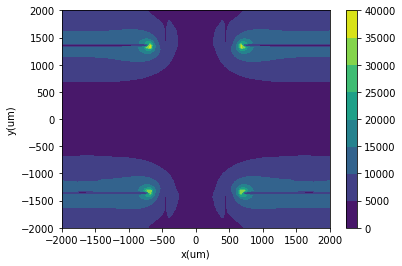

In [18]:
x = np.linspace(-2.0e-3, 2.0e-3, 101)
y = np.linspace(-2.0e-3, 2.0e-3, 101)
X, Y = np.meshgrid(x, y)
E = np.zeros_like(X)
for j in range(len(y)):
    for i in range(len(x)):
        Ex, Ey = trap_DC0.E_field(x[i], y[j], 0)
        E[j][i] = np.sqrt(Ex**2 + Ey**2)
plt.contourf(X*1.0e6, Y*1.0e6, E)
plt.xlabel("x(um)")
plt.ylabel("y(um)")
plt.colorbar()

## Defining simulation functions (RF + a time weighted linear combination of DC voltages )

In [97]:
1+np.array([1,2,3])

array([2, 3, 4])

In [20]:
def E_field_sim(state, time):
    # this is a function that takes in a 2-element array state and a number time.
    # state[0] is current position and state[1] is current velocity.
    # it calculates the derivative of state, and returns a 2-element array,
    # with the 0th element being derivative of position and the 1th being 
    # the acceleration
    g0 = state[1]
    x, y = state[0] 
    def RF_ac(x, y, time):
        if y > trap_RF.y_max:
            return 0
        else:
            return trap_RF.acceleration(x, y, time)
    ramp_time = 5.0e-9
    if time < ramp_time:
        g1 = RF_ac(x, y, time) + (1 - time/ramp_time) * trap_DC0.acceleration(x, y, time) +\
        time/ramp_time * trap_DC1.acceleration(x, y ,time)
    else:
        g1 = RF_ac(x, y, time) + trap_DC1.acceleration(x, y, time)
    #g1 = trap_RF.acceleration(x, y, time) + trap_DC0.acceleration(x, y, time)
    return np.array([g0, g1])

def extracted(rho, phi, v, theta, dt, t_max):
    electron_pos=np.array([rho*np.cos(phi), rho*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    extracted = False
    
    # actual simulation
    while t < t_max:
        x, y = state[0]
        if trap_DC1.hit_electrodes(x, y):
            break
        if y > trap_DC1.y_max:
            extracted = True
            break
        if not trap_DC1.within_boundary(x, y):
            break
        state = trap_DC1.rk4(state, t, dt, E_field_sim)
        t += dt
    return extracted, x, y

def plot_traj(rho, phi, T, theta, dt, t_max):
    v = np.sqrt(2*kB*T/m) #speed
    electron_pos=np.array([rho*np.cos(phi), rho*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    x_traj = []
    y_traj = []
    t_s = []
    trapped = True

    # actual simulation
    while t < t_max:
        x, y = state[0]
        if not trap_DC1.within_boundary(x, y):
            print("out of bound")
            trapped = False
            break
        x_traj.append(x)
        y_traj.append(y)
        t_s.append(t)
        state = trap_RF.rk4(state, t, dt, E_field_sim)
        t += dt
    x_traj, y_traj, t_s = np.array(x_traj), np.array(y_traj), np.array(t_s)

    print("Time step for simulation: ", dt*1.0e9, "ns")
    print("Simulation time duration: ", round(t*1.0e6, 3), "us")

    plt.figure()
    plt.plot(t_s*1.0e6, x_traj*1.0e6)
    plt.xlabel("Time (us)")
    plt.ylabel("x (um)")

    plt.figure()
    plt.plot(t_s*1.0e6, y_traj*1.0e6)
    plt.xlabel("Time (us)")
    plt.ylabel("y (um)")

    plt.figure()
    plt.plot(x_traj*1.0e6, y_traj*1.0e6)
    plt.xlabel("x (um)")
    plt.ylabel("y (um)")
    electrode = df_DC1.loc[(np.abs(df_DC1["Ex"]) < 1.0e-8) & (np.abs(df_DC1["Ey"]) < 1.0e-8)]
    x_electrode = electrode.iloc[:, 0].values
    y_electrode = electrode.iloc[:, 1].values
    plt.plot(x_electrode*1.0e6, y_electrode*1.0e6, "r.")
    plt.plot(-x_electrode*1.0e6, y_electrode*1.0e6, "r.")


out of bound
Time step for simulation:  0.01 ns
Simulation time duration:  0.006 us
True


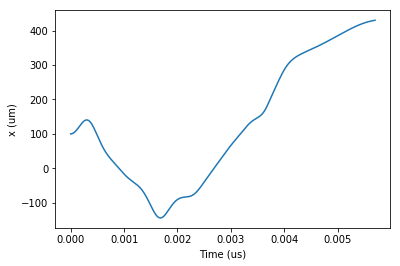

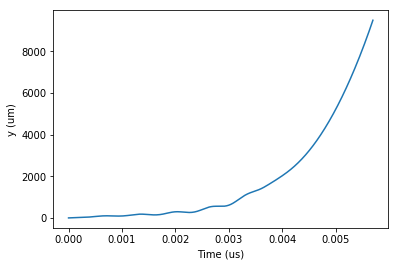

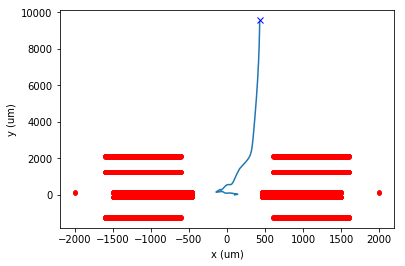

In [110]:
rho = 100.0e-6
phi = 0.0
T = 300.0
v = np.sqrt(2*kB*T/m)
theta = np.pi/2
dt = 1.0e-11
t_max = 1.0e-7
result = plot_traj(rho, phi, T, theta, dt, t_max)
succ, x_f, y_f = extracted(rho, phi, v, theta, dt, t_max)
print(succ)
plt.plot(x_f*1.0e6, y_f*1.0e6, 'bx')

Simulating T =  5000.0 kelvin
The result for T =  5000.0 kelvin:
Simulating T =  1000.0 kelvin
The result for T =  1000.0 kelvin:
Simulating T =  300.0 kelvin
The result for T =  300.0 kelvin:
Simulating T =  20.0 kelvin
The result for T =  20.0 kelvin:
Simulating T =  4.0 kelvin
The result for T =  4.0 kelvin:


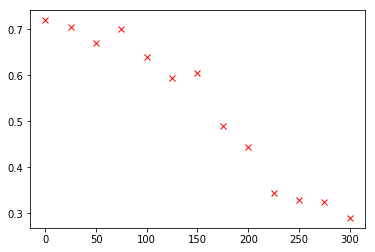

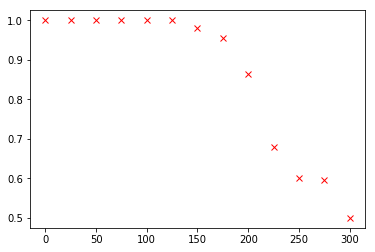

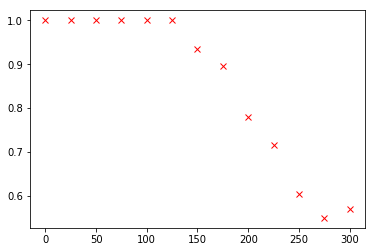

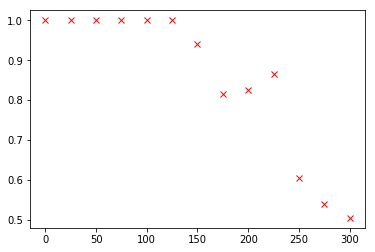

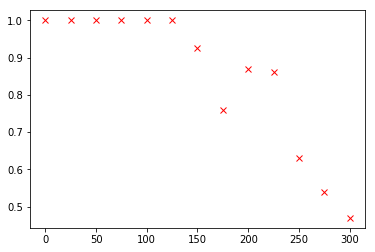

In [29]:
dt = 1.0e-11 #s
t_max = 5.0e-8 # maximum time duration of the simulation

#initial condition
rho_s = [i * 25.0 for i in range(13)]
rho_s = np.array(rho_s) * 1.0e-6
N_samples = 200

# A dictionary, taking temperature as key and the value is a 
# list of success rates correspond to each rho in rho_s
success_rate = dict() 
errors = dict()
for T in [5000.0, 1000.0, 300.0, 20.0, 4.0]:
    v = np.sqrt(2*kB*T/m)
    success_rate[T] = [] 
    errors[T] = []
    print("Simulating T = ", T, "kelvin")
    for rho in rho_s:
        result = []
        phi = np.random.rand(N_samples) * np.pi * 2
        theta = np.random.rand(N_samples) * np.pi * 2
        for i in range(len(phi)):
            success, x_f, y_f = extracted(rho, phi[i], v, theta[i], dt, t_max)
            event_log.append([rho, v, x_f, y_f, success])
            if success:
                result.append(1)
            else:
                result.append(0)
        success_rate[T].append(np.mean(result))
        errors[T].append(np.std(result)/np.sqrt(N_samples))
    print("The result for T = ", T, "kelvin:")
    plt.figure()
    plt.plot(rho_s*1.0e6, success_rate[T], 'rx')
    

In [30]:
event_log_arr = np.array(event_log)
df_event = pd.DataFrame(event_log_arr, columns=['rho_0', 'v_0', 'x_f', 'y_f', 'extracted'])

Text(0,0.5,'y (um)')

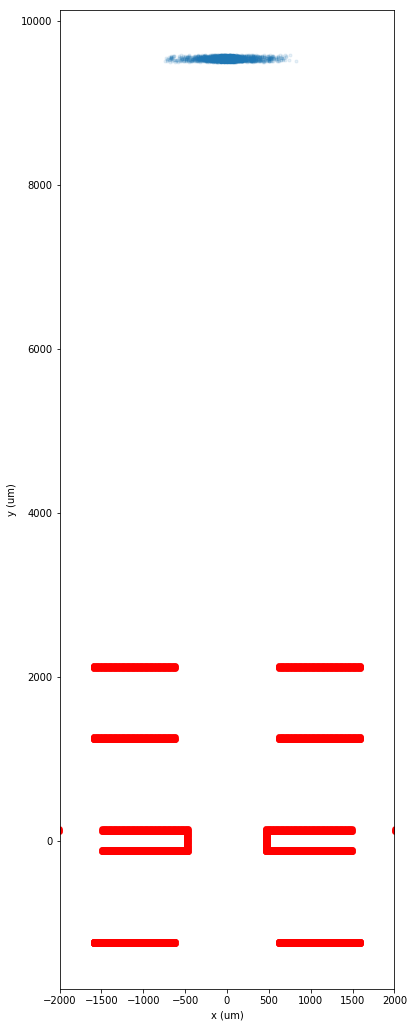

In [31]:
#x_fail = df_event[(df_event.extracted == 1.0)].x_f.values
#y_fail = df_event[(df_event.extracted == 1.0)].y_f.values
x_fail = df_event[(df_event.extracted == 1.0) & (df_event.rho_0 < 100.0e-6) & (round(0.5*m*df_event.v_0**2/kB)==300)].x_f.values
y_fail = df_event[(df_event.extracted == 1.0) & (df_event.rho_0 < 100.0e-6) & (round(0.5*m*df_event.v_0**2/kB)==300)].y_f.values
plt.figure(figsize=(6, 18))
electrode = df_DC1.loc[(np.abs(df_DC1["Ex"]) < 1.0e-8) & (np.abs(df_DC1["Ey"]) < 1.0e-8)]
x_electrode = electrode.iloc[:, 0].values
y_electrode = electrode.iloc[:, 1].values
plt.plot(x_electrode*1.0e6, y_electrode*1.0e6, ".", color='red')
plt.plot(-x_electrode*1.0e6, y_electrode*1.0e6, ".", color='red')
plt.scatter(x_fail*1.0e6, y_fail*1.0e6, alpha=0.1, marker='.')
#plt.plot(x_fail*1.0e6, y_fail*1.0e6, 'bx')
plt.xlim(-trap_DC1.x_max*1.0e6, trap_DC1.x_max*1.0e6)
plt.xlabel("x (um)")
plt.ylabel("y (um)")

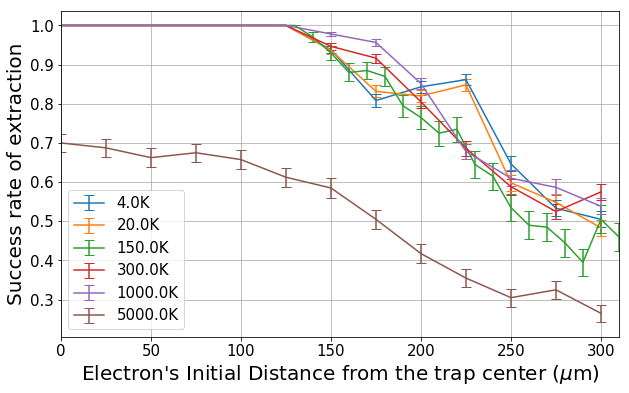

In [32]:
plt.figure(figsize=(10, 6))
vs = df_event.v_0.unique()
vs.sort()
for v in vs:
    T = 0.5*m*v**2/kB
#     if round(T) == 20 or round(T)==100:
#         continue
    rhos = df_event[df_event.v_0 == v].rho_0.unique()
    rhos.sort()
    success_rate = []
    err = []
    for rho in rhos:
        mean = df_event[(df_event.v_0==v) & (df_event.rho_0==rho)].iloc[:, 4].mean()
        std = df_event[(df_event.v_0==v) & (df_event.rho_0==rho)].iloc[:, 4].std()
        N = df_event[(df_event.v_0==v) & (df_event.rho_0==rho)].shape[0]
        success_rate.append(mean)
        err.append(std/np.sqrt(N))
    plt.errorbar(rhos*1.0e6, success_rate, yerr=err, label = str(round(T)) + "K", capsize=5)
    #plt.plot(rhos*1.0e6, success_rate, label = str(round(T)) + "K")
plt.grid(True)  
plt.xlabel("Electron's Initial Distance from the trap center ($\mu$m)", fontsize=20)
plt.ylabel("Success rate of extraction", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0, 310)
plt.legend(fontsize=15)

In [33]:
a = np.array([[1,2,300],[4000,5,6],[7,8,9]])

# writing out the result
file = open("event_log_extraction_5ns_ramp.txt","w") 
file.write("rho, v, x_final, y_final, successful extraction\n")
for row in event_log:
    for elem in row:
        file.write(str(float(elem))+" ")
    file.write("\n")
file.close()

In [28]:
# event_log_arr = np.loadtxt("event_log_extraction_5ns_ramp.txt", skiprows=1)
# event_log = event_log_arr.tolist()